Kolom Data Latih: ['ID', 'label', 'tanggal', 'judul', 'narasi', 'nama file gambar']
Kolom Data Uji: ['ID', 'tanggal', 'judul', 'narasi', 'nama file gambar']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\darre\AppData\Local\Temp\ipykernel_40056\4116989490.py:89: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # mixed precision for speed
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/1:   0%|          | 0/133 [00:00<?, ?it/s]C:\Users\darre\AppData\Local\Temp\ipykernel_40056\4116989490.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda'

✅ Epoch 1 done | Avg Loss: 0.4334 | Time: 822.1s


Evaluating: 100%|██████████| 133/133 [02:40<00:00,  1.21s/it]



Classification Report:
              precision    recall  f1-score   support

    Non-Hoax       0.75      0.32      0.45       361
        Hoax       0.88      0.98      0.92      1755

    accuracy                           0.87      2116
   macro avg       0.82      0.65      0.69      2116
weighted avg       0.85      0.87      0.84      2116



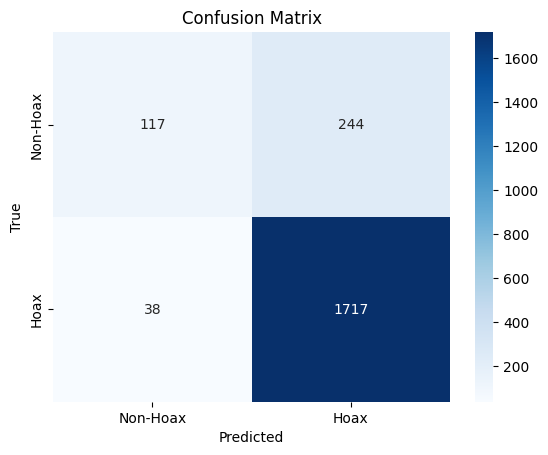


✅ Model disimpan di folder 'hoax_detector_model_fast/'


In [ ]:
import pandas as pd
import numpy as np
import re, string, torch, time
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================================
# 1. LOAD DATA
# ==========================================================
train_df = pd.read_csv("Data_latih.csv")
test_df = pd.read_csv("Data_uji.csv")

print("Kolom Data Latih:", list(train_df.columns))
print("Kolom Data Uji:", list(test_df.columns))

# Use text columns and label
train_df = train_df[['narasi', 'label']].rename(columns={'narasi': 'text'})
test_df = test_df[['narasi']].rename(columns={'narasi': 'text'})

# ==========================================================
# 2. PREPROCESS TEKS
# ==========================================================
factory = StopWordRemoverFactory()
stopwords = factory.create_stop_word_remover()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = stopwords.remove(text)
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# ==========================================================
# 3. TOKENIZER + DATASET
# ==========================================================
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

class NewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Use half data first if want to have fast progress
train_df = train_df.sample(frac=0.5, random_state=42).reset_index(drop=True)

train_dataset = NewsDataset(train_df['clean_text'].tolist(), train_df['label'].tolist(), tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# ==========================================================
# 4. MODEL SETUP
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=3e-5)
epochs = 1
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)

scaler = torch.cuda.amp.GradScaler()  # mixed precision for speed

# ==========================================================
# 5. TRAINING (with tqdm progress bar)
# ==========================================================
model.train()
for epoch in range(epochs):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    start_time = time.time()

    for batch in progress_bar:
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items()}

        with torch.cuda.amp.autocast():
            outputs = model(**inputs)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    elapsed = time.time() - start_time
    print(f"✅ Epoch {epoch+1} done | Avg Loss: {total_loss/len(train_loader):.4f} | Time: {elapsed:.1f}s")

# ==========================================================
# 6. EVALUATION (simple validation on training)
# ==========================================================
model.eval()
preds, labels = [], []
for batch in tqdm(train_loader, desc="Evaluating"):
    inputs = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
    labels.extend(inputs['labels'].cpu().numpy())

print("\nClassification Report:")
print(classification_report(labels, preds, target_names=["Non-Hoax", "Hoax"]))

# Confusion matrix
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Hoax","Hoax"], yticklabels=["Non-Hoax","Hoax"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

# ==========================================================
# 7. SAVE MODEL
# ==========================================================
model.save_pretrained("hoax_detector_model_fast")
tokenizer.save_pretrained("hoax_detector_model_fast")

print("\n✅ Model disimpan di folder 'hoax_detector_model_fast/'")
